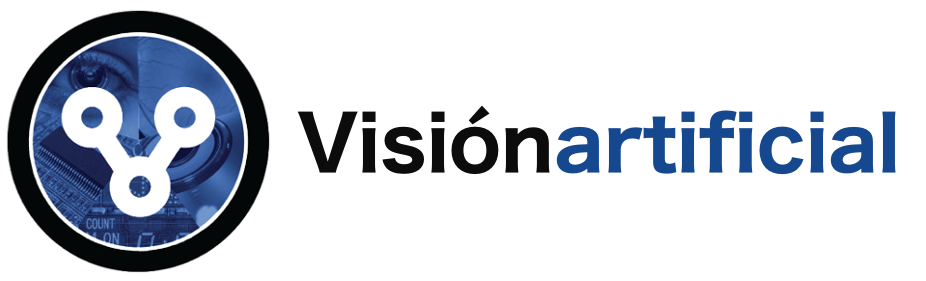

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

# <h1 style="font-size:30px;">Análise frecuencial en imágenes</h1>



Jean Baptiste Joseph Fourier (1786-1830) presentou unha idea novidosa:

**Cualquiera función univariante pódese reescribir como unha suma de senos e cosenos de diferentes frecuencias (1807)**
Esta idea non foi aceptada de inmediato e de feito, non se traduciu ao inglés ata 1878. Sen embargo, era certo e a esta suma lle chamamos **Serie de Fourier**.

Neste caderno, trataremos as bases deste espazo transformado abodando os seguintes puntos:

    1. Transformada de Fourier
    2. Filtrado de imaxes no dominio frecuencial
    3. Suavidade nas imaxes
    4. Filtrado paso-baixo antes do mostreo
    5. Teorema de Nyquist

### <font style="color:rgb(200,0,0)">**Nota:** Para presentación executa: jupyter nbconvert nome_do_caderno.ipynb --to slides --post serve </font>


O obxectivo desta sección é amosar que a análise de frecuencia non é máis que un cambio de base como os estudados en álxebra lineal (aínda que na práctica faise cun algoritmo máis eficiente). 

Expresión dun vector en dúas bases:

$$\begin{bmatrix}2\\-3\\8\\4\end{bmatrix}\; =\; 2 \begin{bmatrix}{\color{red}1}\\0\\0\\0\end{bmatrix} -3 \begin{bmatrix}0\\{\color{red}1}\\0\\0\end{bmatrix} + 8 \begin{bmatrix}0\\0\\{\color{red}1}\\0\end{bmatrix} + 4 \begin{bmatrix}0\\0\\0\\{\color{red}1}\end{bmatrix} \; =\; 5.5 \begin{bmatrix}0.5\\0.5\\0.5\\0.5\end{bmatrix} -4.3 \begin{bmatrix}0.65\\0.27\\-0.27\\-0.65\end{bmatrix} + 0.5 \begin{bmatrix}0.5\\-0.5\\-0.5\\0.5\end{bmatrix} + 6.6 \begin{bmatrix}0.27\\-0.65\\0.65\\-0.27\end{bmatrix}$$

A primeira base é a canónica e a segunda é outra distinta.

## A base de Fourier

Calquera sinal pódese expresar como unha combinación de ondas de diferentes frecuencias.

$$ f(x) = \sum_\omega A_\omega \cos(2\pi \omega x + \phi_\omega) $$

Cada frecuencia $\omega$ achega unha certa amplitude $A_\omega$ e un desprazamento $\phi_\omega$. A Transformada de Fourier é un algoritmo que analiza o sinal e obtén estes dous ingredientes.

Matematicamente é moito mellor usar ondas **complexas**

$$ f(x) = \sum _ \omega F_\omega  e ^ {2 \pi i \omega x} $$

onde os coeficientes codifican nun número complexo a amplitude e o desprazamento de cada frecuencia.

$$ F_\omega = A e^{i \phi_\omega} $$

Hai unha explicación máis detallada [neste documento] (https://robot.inf.um.es/material/va/percep.pdf#appendix.B), que tamén inclúe unha interpretación xeométrica da base de exponenciais complexas.

# <font style="color:rgb(50,120,229)">Importamos as librerias necesarias</font>

In [1]:
# Importamos as librerias
import cv2
import scipy as sp
from scipy import signal
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
%matplotlib inline

/home/lkipo/.virtualenvs/VAA/lib64/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/lkipo/.virtualenvs/VAA/lib64/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/lkipo/.virtualenvs/VAA/lib64/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/lkipo/.virtualenvs/VAA/lib64/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

Como exemplo, xeramos un sinal con compoñentes de frecuencia coñecidos e vemos a FFT os atopa: 
    

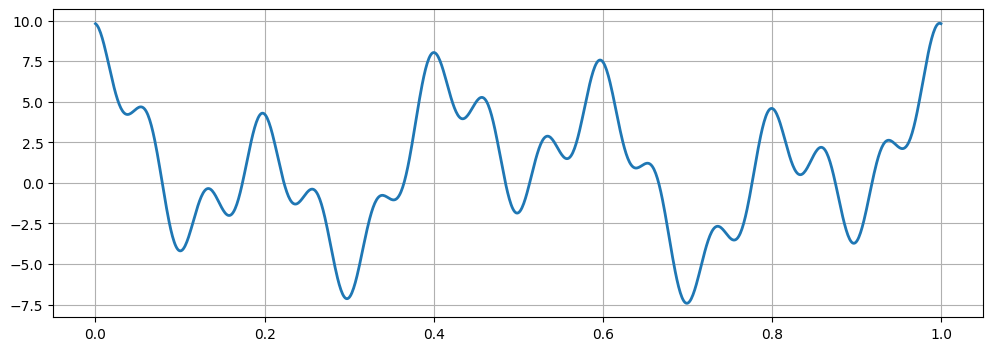

In [3]:
# compoñente frecuencial de amplitude a, frecuencia w e fase d
def C(w,d,x):
    return np.cos(2*np.pi*w*x+d)

def fun(x):
    return 1 + 3*C(2,0.1,x) + 4*C(5,-0.2,x) + 2*C(15,0.3,x)

x = np.linspace(0,1,1000)

plt.figure(figsize=(12,4))
plt.plot(x,fun(x),lw=2);
plt.grid();

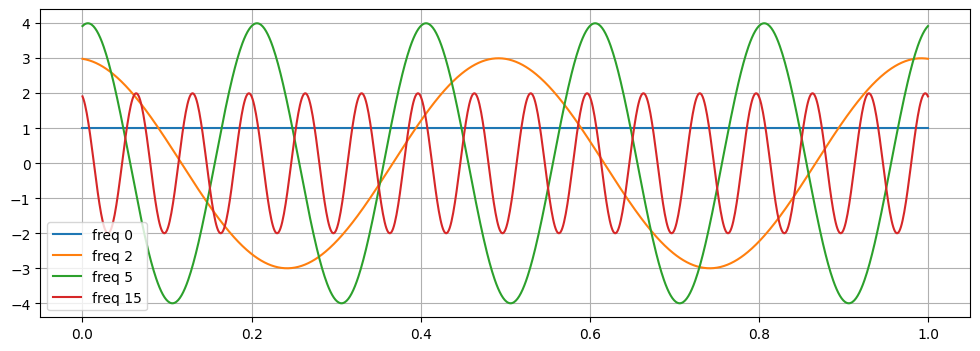

In [5]:
#Conseguimos a sinal sunamdo estes catro armónicos
plt.figure(figsize=(12,4))
plt.plot(x,1*C(0,0,x), label='freq 0')
plt.plot(x,3*C(2,0.1,x), label='freq 2')
plt.plot(x,4*C(5,-0.2,x), label='freq 5')
plt.plot(x,2*C(15,0.3,x), label='freq 15');
plt.grid(); plt.legend()

Na práctica, só observamos un mostreo da sinal

[ 9.81595179  6.30286858  4.24035093  4.40848432 -0.32957162 -4.19336136
 -1.59759719 -0.62238073 -1.97947832  1.54265739  4.23997162  0.6004706
 -1.23016223 -0.48641156 -4.34128591 -7.0698233  -3.15806809 -0.76881047
 -0.70266617  4.16248461  8.03820054  5.33844453  4.14985238  5.19759762
  1.28957065 -1.84592679  1.33063173  2.70265116  1.53343255  5.02271813
  7.46851721  3.37463965  0.91531904  0.89557345 -3.80963236 -7.42190696
 -4.37176625 -2.767862   -3.36146333  1.01100384  4.59205528  1.81416876
  0.76888931  2.17238559 -1.18980513 -3.62367804  0.36620768  2.6121526
  2.32254585  6.6418604 ]


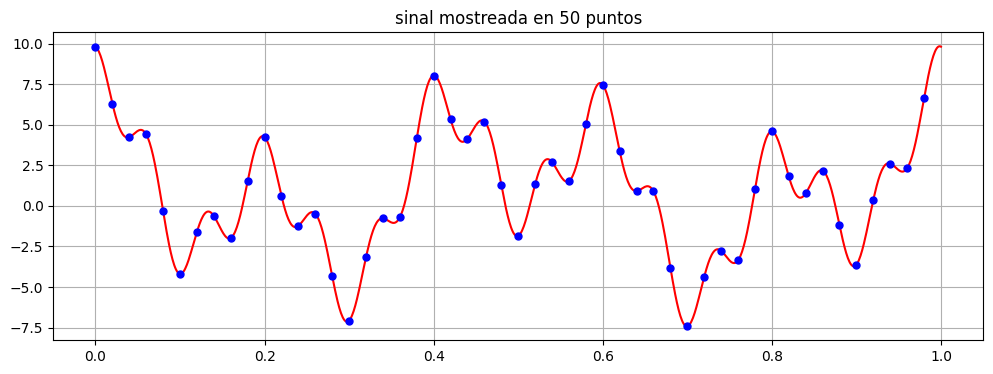

In [6]:
#xeramos a sinal mostreada cun intervalo delta
delta = 0.02
xs =  np.linspace(0,1-delta,50)
f = fun(xs)

print(f)

plt.figure(figsize=(12,4))
plt.plot(x,fun(x),'r',xs,f,'.b',markersize=10); plt.grid()
plt.title('sinal mostreada en 50 puntos');

O algoritmo FFT (transformada discreta de Fourier rápida) analiza o sinal mostreado e devolve as amplitudes e fases das compoñentes, aínda que o fai dun xeito un tanto especial, codificando o módulo e o desfase como números complexos situados en dúas posicións da matriz resultante.

**RECORDATORIO:** Numpy admite números complexos.

 Dado un número complexo `x`:

     np.complex() constrúe un número complexo
     x.real refírese a compoñente real
     x.imag refírese a compoñente imaxinario
     np.abs(x) calcula a magnitude (ou amplitude)
     np.angle(x) calcula o ángulo en radianes (ou fase) 

In [7]:
# dividimos por n para que a escala global da FFT coincida coas amplitudes
F = fft.fft(f)/len(f)

# para visualizar mellor o array, quitamos os ceros numéricos
F[abs(F)<1E-10] = 0

F

array([1.        +0.j        , 0.        +0.j        ,
       1.49250625+0.14975012j, 0.        +0.j        ,
       0.        +0.j        , 1.96013316-0.39733866j,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.95533649+0.29552021j,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.95533649-0.29552021j,
       0. 

Imos manipular un pouco a matriz para extraer os compoñentes do sinal. O módulo do resultado:

In [8]:
abs(F)

array([1. , 0. , 1.5, 0. , 0. , 2. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 2. , 0. , 0. , 1.5, 0. ])

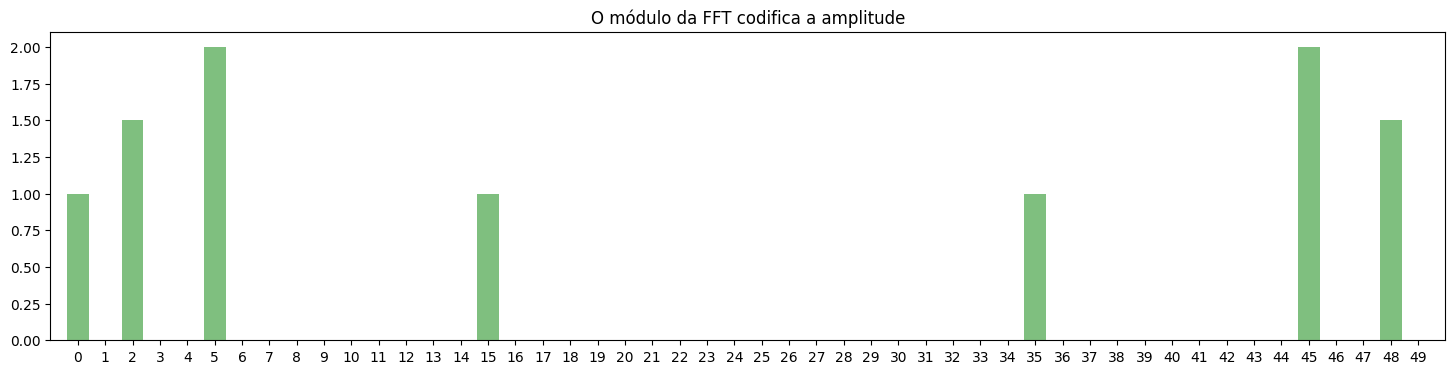

In [9]:
w = np.array(range(len(F)))

plt.figure(figsize=(18,4))
plt.bar(w,abs(F), color='green',alpha=0.5)
plt.xticks(w); plt.axis([-1,50,0,2.1]);
plt.title('O módulo da FFT codifica a amplitude');

E a fase:

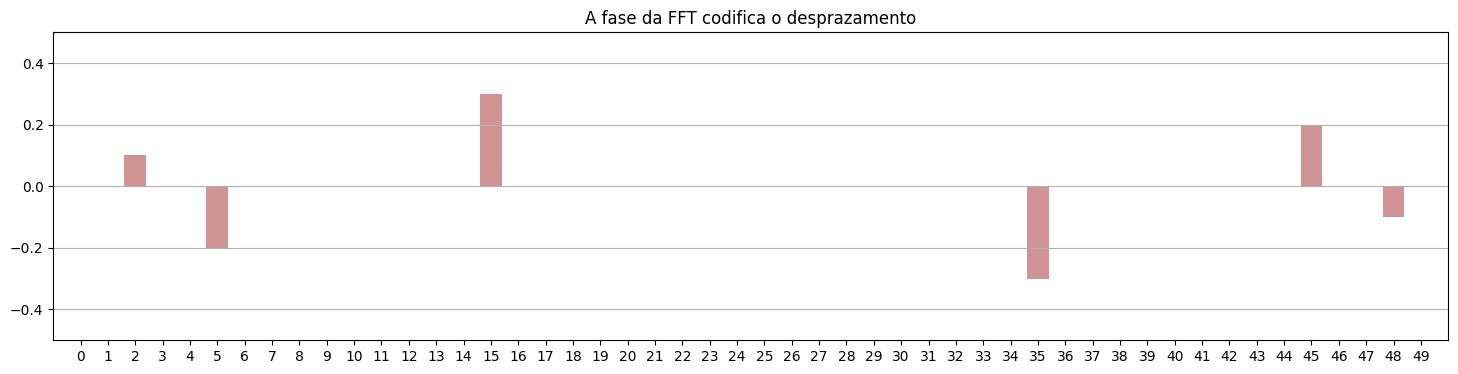

In [10]:
w = np.array(range(len(F)))

plt.figure(figsize=(18,4))
plt.bar(w,np.angle(F), color='brown',alpha=0.5)
plt.xticks(w); plt.axis([-1,50,-0.5,0.5]);
#plt.grid()
plt.title('A fase da FFT codifica o desprazamento');
plt.grid(axis='y')

Vemos que a magnitude da transformada de Fourier, que é un sinal complexo, contén a amplitude de cada onda $ A_\omega $ e a "fase" é o desprazamento $ \phi_\omega $. Ten en conta que cada frecuencia $ \omega $ aparece na transformación en dúas posicións, correspondentes a $ \omega $ e $ - \omega $ (que en realidade son a mesma onda) e que as frecuencias negativas aparecen ao final do vector.

O FFT é periódico e, polo tanto, as frecuencias superiores a $ N / 2 $ (o máximo que se pode detectar) son equivalentes a frecuencias negativas. O normal é amosar o fft "volteado" ou "centrado" para poñer as baixas frecuencias no centro do vector.

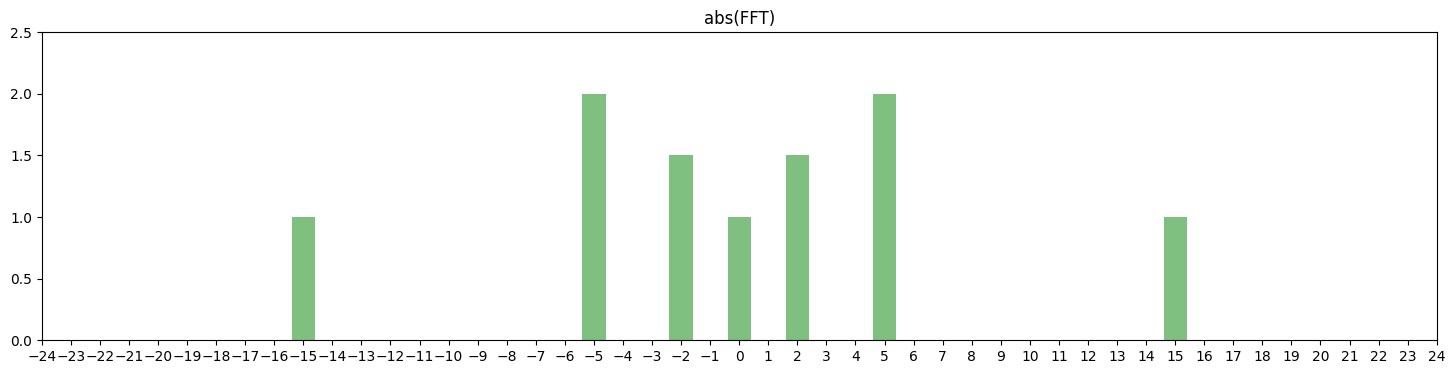

In [11]:
n = len(F)
n2 = (n+1) // 2
w = np.array(range(len(F)))
ws = np.roll(w,n2)
Fs = np.roll(F,n2)


plt.figure(figsize=(18,4))
plt.bar(w-25,abs(Fs), color='green',alpha=0.5)
plt.xticks(w-25); 
plt.axis([-24,24,0,2.5]);
plt.title('abs(FFT)');

Cando o sinal é real, como neste exemplo, a FFT ten simetría complexa conxugada. As frecuencias negativas teñen a mesma amplitude absoluta cas positivas, polo que podemos visualizar soamente as frecuencias positivas: 

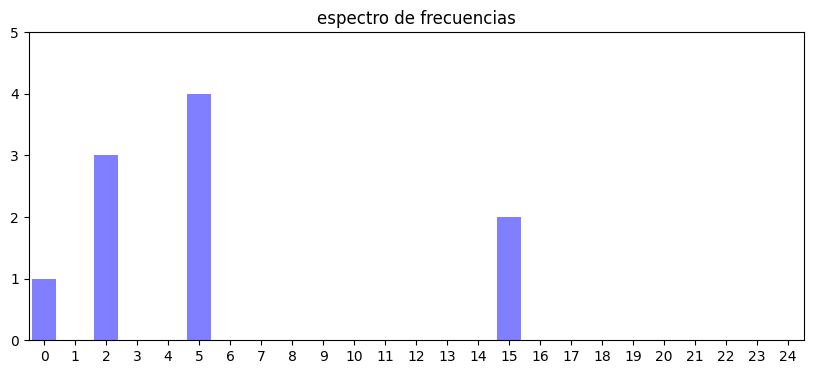

In [12]:
n2 = len(F)//2
P = abs(F)[:n2]
P[2:] *= 2
plt.figure(figsize=(10,4))
plt.bar(w[:n2],P, color='blue',alpha=0.5)
plt.xticks(w[:n2]); 
plt.axis([-.5,24.5,0,5]);
plt.title('espectro de frecuencias');

Estas amplitudes coinciden con los coeficientes utilizados para definir `fun`. 
Se se toman $ n $ mostras, só se pode analizar ata a frecuencia $ n \over 2 $. 


# <font style="color:rgb(50,120,229)">Teorema de Parseval ou potencia espectral</font>
A enerxía da sinal repártese entre as diferentes frecuencias:
$$\int_t \left|x(t)\right|^2 dt = \int_\omega \left|F(\omega)\right|^2 d \omega$$

### Transformada inversa

Podemos sintetizar ondas creando un vector coas amplitudes de cada frecuencia e aplicando a transformada inversa:

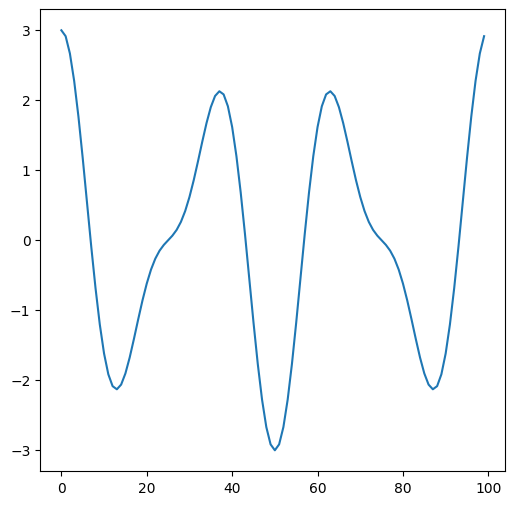

In [13]:
F = np.zeros(100,dtype=complex)
F[3] = 2
F[5] = 1
f = fft.ifft(F)*len(F)
plt.plot(np.real(f));

### Teorema de Nyquist (ou teorema de mostraxe) 

O teorema de Nyquist afirma que, para reproducir adecuadamente un sinal, debe ser mostrado periodicamente a unha velocidade que é dúas veces a frecuencia máis alta que se desexa representar. ¶


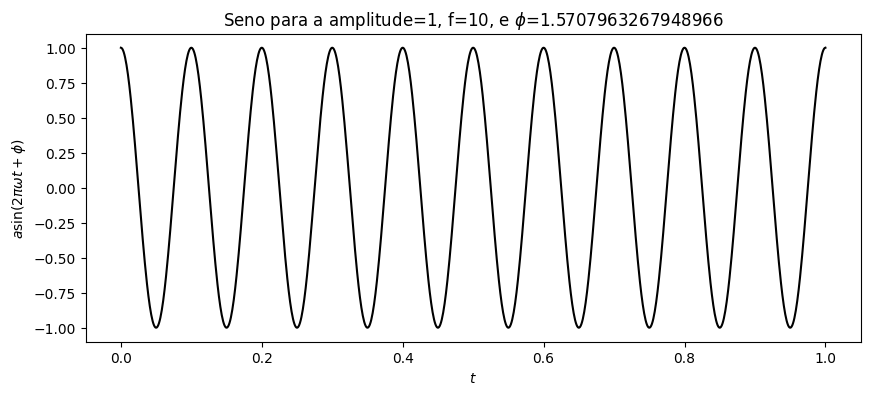

In [14]:
t = np.linspace(0, 1, 1000)

a = 1
f = 10 # frecuencia da sinal
p = np.pi/2
omega = 2 * np.pi * f
y = a * np.sin( omega * t + p)

plt.figure(figsize=(10, 4))
plt.title(f'Seno para a amplitude={a}, f={f}, e $\phi$={p}')
plt.plot(t, y, 'k')
plt.xlabel('$t$')
plt.ylabel('$a \sin(2 \pi \omega t + \phi)$');

## Mostreo (conversión analóxico-dixital)

A mostreo realízase para realizar conversión analóxica a dixital. 

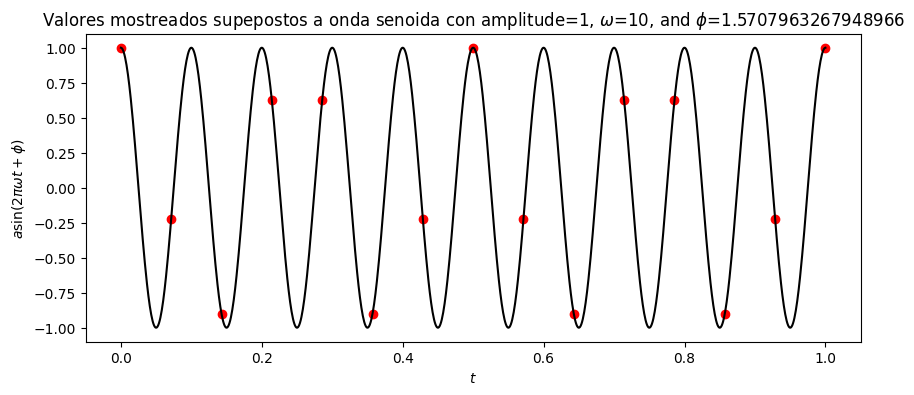

In [15]:
Fs = 14 # frecuencia de mostreo
T = 1/Fs # periodo de mostreo
sampling_duration = 1 # segundos de mostreo
N = Fs * sampling_duration + 1 # numero total de puntos na sinal

t_sampled = np.arange(N)*T
y_discretized = a * np.sin( omega * t_sampled + p)

#Visualizamos
plt.figure(figsize=(10, 4))
plt.title(f'Valores mostreados supepostos a onda senoida con amplitude={a}, $\omega$={f}, and $\phi$={p}')
plt.plot(t, y, 'k')
plt.scatter(t_sampled, y_discretized, color='red')
plt.xlabel('$t$')
plt.ylabel('$a \sin(2 \pi \omega t + \phi)$');

## Reconstrución (conversión dixital a analóxica)

Usamos unha das moitas técnicas de interpolación dispoñibles para reconstruír o sinal analóxico.

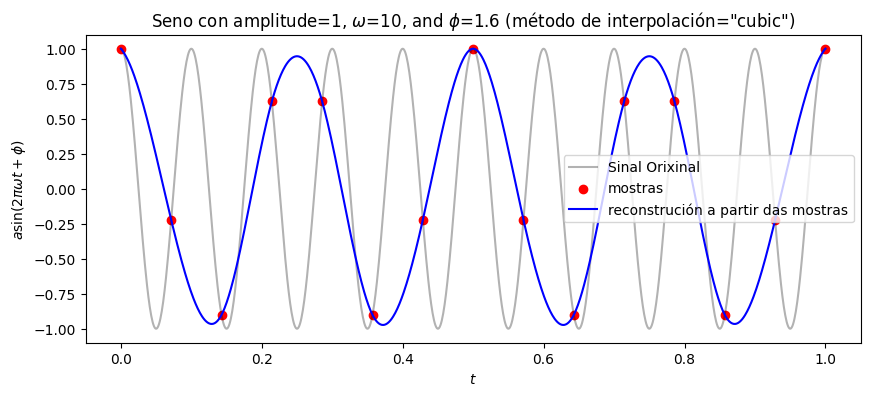

In [16]:
from scipy import interpolate

method = 'previous'
method = 'cubic'
y_reconstructed_from_samples1 = interpolate.interp1d(t_sampled, y_discretized, kind=method)(t)

#Visualizamos a reconstrucion da sinal a partir do mostreo
plt.figure(figsize=(10, 4))
plt.title(f'Seno con amplitude={a}, $\omega$={f}, and $\phi$={p:3.2} (método de interpolación="{method}")')
plt.plot(t, y, 'k', label='Sinal Orixinal', alpha=0.3)
plt.scatter(t_sampled, y_discretized, color='red', label='mostras')
plt.plot(t, y_reconstructed_from_samples1, 'b', label='reconstrución a partir das mostras')
plt.xlabel('$t$')
plt.legend()
plt.ylabel('$a \sin(2 \pi \omega t + \phi)$');

## Teorema da convolución

A transformada de Fourier da convolución de dúas funcións é o produto das súas transformadas de Fourier.
$$\mathcal{F}\{g \ast h\} = \mathcal{F}\{g\} \ast \mathcal{F}\{h\}$$

A transformada de Fourier inversa do produto de dúas transformadas de Fourier é a convolución das dúas transformadas de Fourier inversas.
$$\mathcal{F}^{-1}\{g h\} = \mathcal{F}^{-1}\{g\} \ast \mathcal{F}^{-1}\{h\}$$

A convolución no dominio espacial equivale á multiplicación no dominio da frecuencia.

## Propiedades da transformada de Fourier

- A transformada de Fourier dunha sinal real é simétrica ao redor da orixe.
- A enerxía da sinal é a mesma que a enerxía da súa transformada de Fourier.
- Linealidade 

$$\mathcal{F}\{a g(x) + b h(x)\} = a \mathcal{F}\{g(x)\} + b \mathcal{F}\{h(x)\}$$

# Transformada de Fourier dunha imaxe 

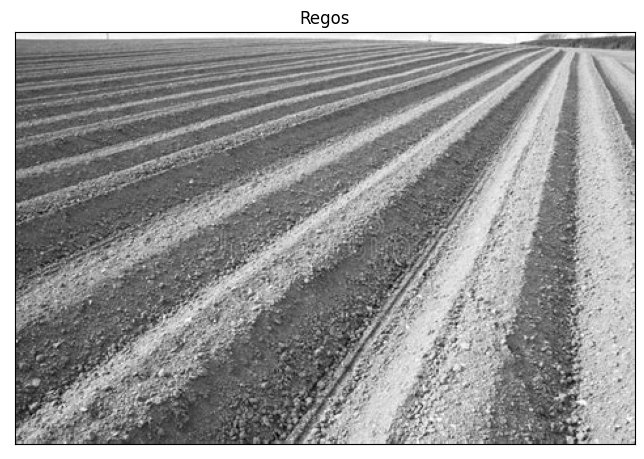

In [17]:
import cv2 as cv
img = cv.imread('data/regos.jpeg', 0)

plt.figure(figsize=(8,8))
plt.imshow(img, 'gray')
plt.title('Regos')
plt.xticks([])
plt.yticks([]);

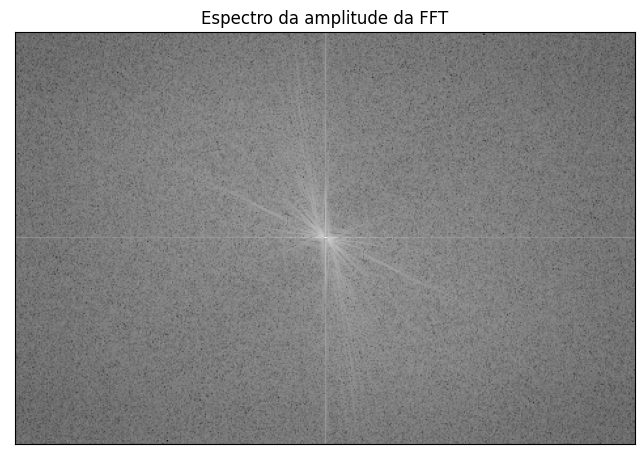

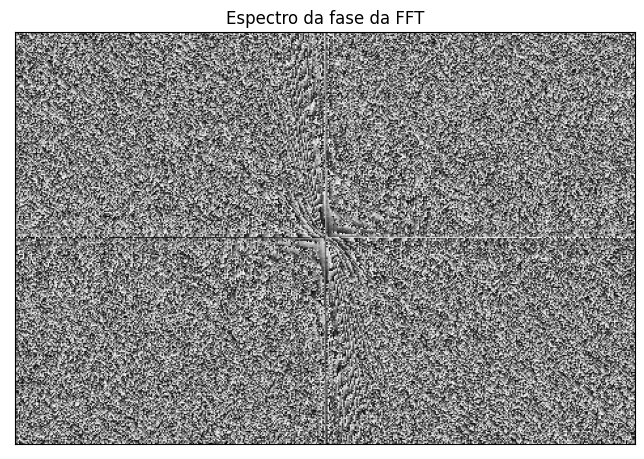

In [18]:

#achamos a FFT 2D
img_fourier = np.fft.fft2(img)
img_fourier_shifted = np.fft.fftshift(img_fourier) #Despramos os cuadrantes: continua no centro da imaxe
img_spectrum_magnitude = 20 * np.log(np.abs(img_fourier_shifted)) #Para comprimir o rango de valores
img_spectrum_phase = np.angle(img_fourier_shifted)

#Visualizamos


plt.figure(figsize=(8,8))
plt.imshow(img_spectrum_magnitude, cmap = 'gray')
plt.title('Espectro da amplitude da FFT')
plt.xticks([])
plt.yticks([]);


plt.figure(figsize=(8,8))
plt.imshow(img_spectrum_phase, cmap = 'gray')
plt.title('Espectro da fase da FFT')
plt.xticks([])
plt.yticks([]);



# Convolución de imaxes usando a transformada de Fourier¶

## Paso 1: constrúe un núcleo gaussiano 2D 

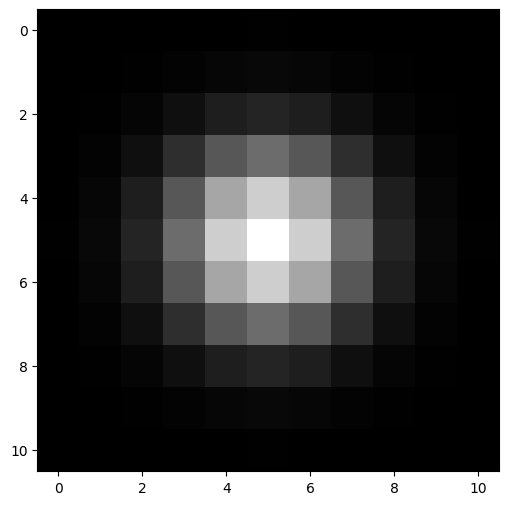

In [19]:
import scipy.stats as st

def gkern(kernlen=5, sig=3):
    """Devolve un kernel Gaussiano 2D."""
    x = np.linspace(-kernlen/(3*sig), kernlen/(3*sig), kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()



g = gkern(kernlen=11, sig=1)
plt.imshow(g)



## Paso 2: Facemos que este kernel teña o mesmo tamaño que a imaxe reenchendo ceros 

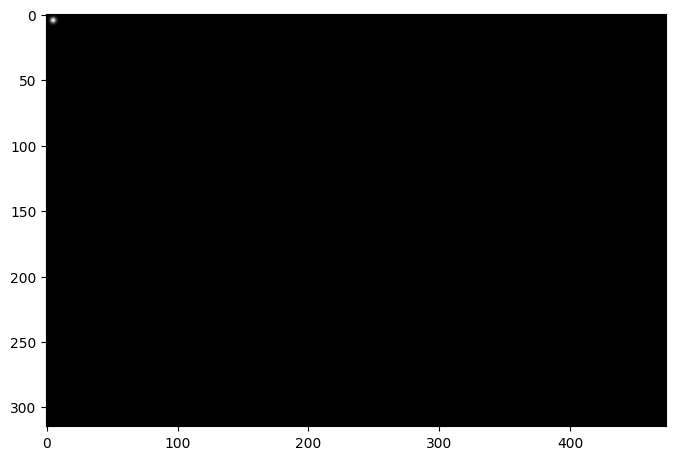

In [20]:
h, w = g.shape
g_resized = np.zeros(img.shape)
g_resized[:h,:w] = g

plt.figure(figsize=(8,8))
plt.imshow(g_resized)

## Paso 3: Toma a súa transformada de Fourier 

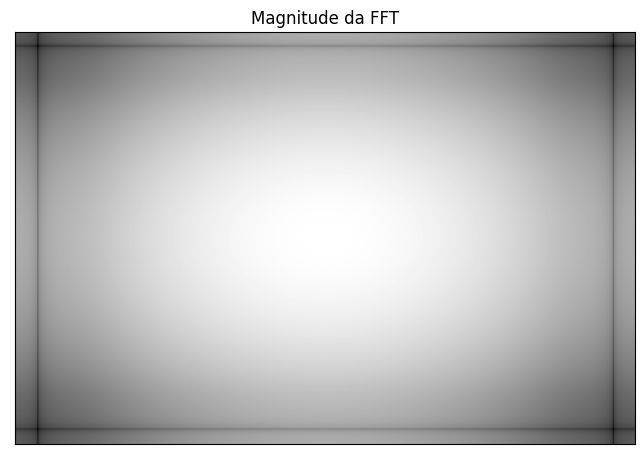

In [21]:
g_fourier = np.fft.fft2(g_resized)
g_fourier_shifted = np.fft.fftshift(g_fourier)
g_spectrum_magnitude = 20 * np.log(np.abs(g_fourier_shifted))

#Visualizamos
plt.figure(figsize=(8,8))
plt.imshow(g_spectrum_magnitude, cmap = 'gray')
plt.title('Magnitude da FFT')
plt.xticks([])
plt.yticks([]);

## Paso 4: multiplica as dúas transformadas de Fourier 

In [22]:
multiplied_fourier = img_fourier * g_fourier


## Paso 5: Toma a transformada de Fourier inversa. 

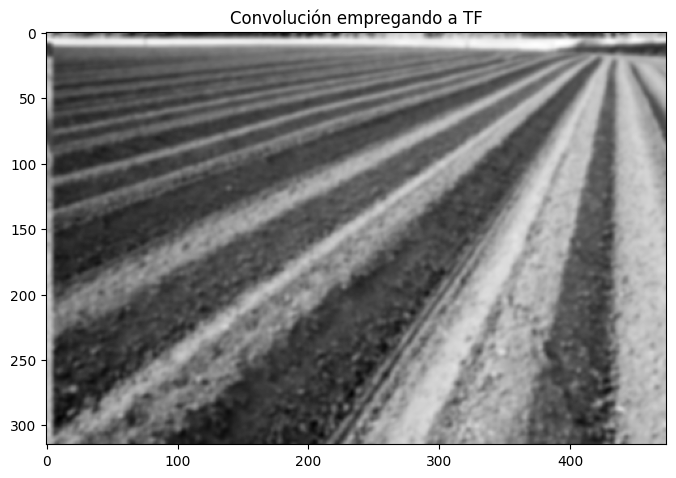

In [23]:
img_filtered = np.real(np.fft.ifft2(multiplied_fourier))


#Visualizamos
plt.figure(figsize=(8,8))
plt.title('Convolución empregando a TF')
plt.imshow(img_filtered, cmap='gray');



## Paso 6: Imos confirmar que obtemos o mesmo resultado se usamos a convolución en dominio espacial. 

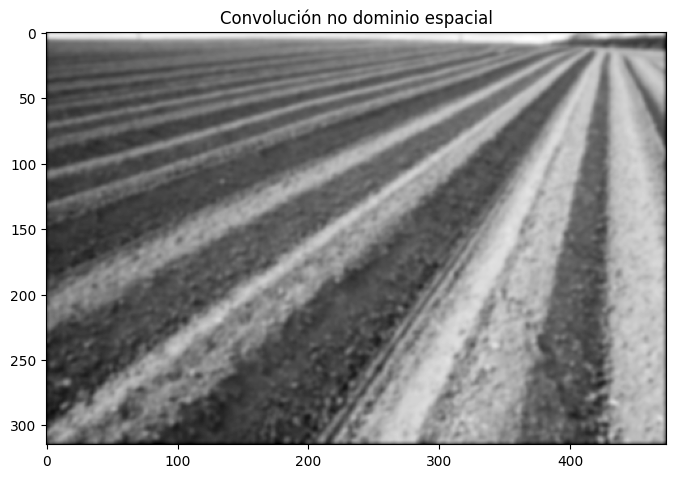

In [24]:
img_filtered2 =  sp.signal.convolve2d(img, g, mode='same', boundary='fill')


#Visualizamos
plt.figure(figsize=(8,8))
plt.title('Convolución no dominio espacial')
plt.imshow(img_filtered2, cmap='gray');



# Por que FFT?

Cando se trata de convolucións, moitas veces é moito máis rápido levalos a cabo no dominio de Fourier. 

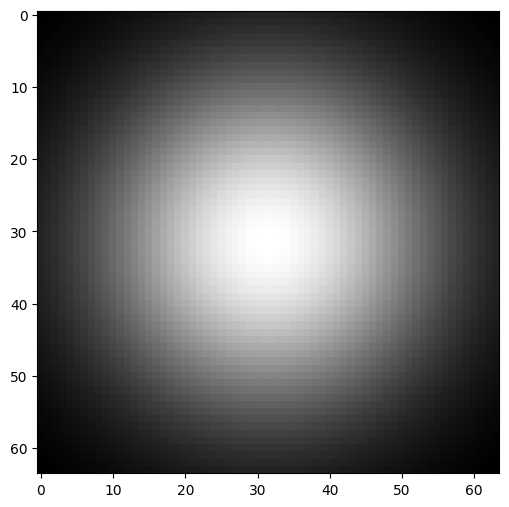

In [25]:
g = gkern(kernlen=64, sig=11)
plt.imshow(g)

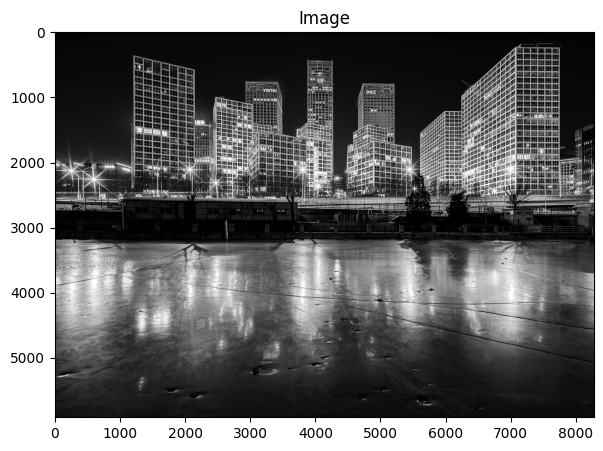

In [26]:
# Imaxe baixada de https://cdn.hasselblad.com/samples/B0000835.jpg
#Imaxe moi grande 5000x8000 pixels

i = cv.imread('data/B0000835.jpg', 0)
plt.figure(figsize=(10,5))
plt.title('Image')
plt.imshow(i, cmap='gray');

In [27]:
%%time
g_resized = np.zeros(i.shape)
h, w = g.shape
g_resized[:h,:w] = g
g_fourier = np.fft.fft2(g_resized)



CPU times: user 2.68 s, sys: 188 ms, total: 2.87 s
Wall time: 2.87 s


In [28]:
%%time
i_fourier = np.fft.fft2(i)
r = i_fourier*g_fourier
i_r = np.abs(np.fft.ifft2(r))



CPU times: user 6.09 s, sys: 475 ms, total: 6.56 s
Wall time: 6.56 s


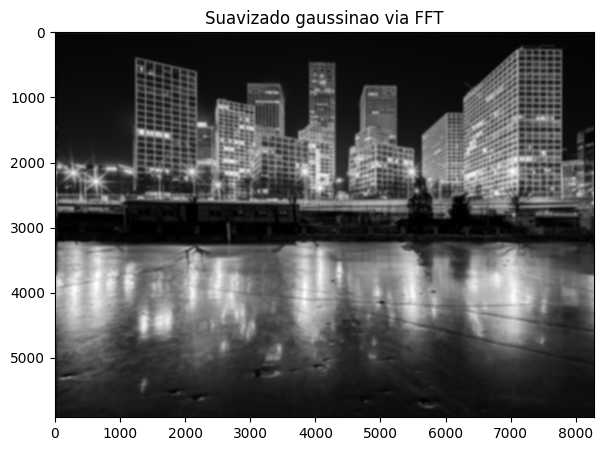

In [29]:
plt.figure(figsize=(10,5))
plt.title('Suavizado gaussinao via FFT')
plt.imshow(i_r, cmap='gray');

In [30]:
%%time
#Convolución no dominio espacial
#Tarda moito tempo! paciencia. No meu portatil case 7 minutos fronte aos 7 s que tarda no dominio de Fourier!

i_r2 = sp.signal.convolve2d(i, g, mode='same', boundary='fill')
cv.imwrite('foo.jpg', i_r2)

In [ ]:
#Visualizamos
i_r3 = cv.imread('foo.jpg')
plt.figure(figsize=(10,5))
plt.title('Suavizado gaussiano SEN FFT')
plt.imshow(i_r3, cmap='gray');

# Enredando coas frecuencias

In [ ]:
img = cv.imread('data/regos.jpeg', 0)

#Achamos a TF
img_fourier = np.fft.fft2(img)
img_fourier_shifted = np.fft.fftshift(img_fourier)
img_spectrum_magnitude = 20 * np.log(np.abs(img_fourier_shifted))

#Visualizamos
plt.figure(figsize=(8,8))
plt.imshow(img_spectrum_magnitude, cmap = 'gray')
plt.title('Espectro da magnitude')
plt.xticks([])
plt.yticks([]);



#Modificamos as frecuencias: anulamos as frecuencias no cadrado central de lado 10
rows, cols = img.shape
crow, ccol = rows//2, cols//2
how_much = 10

img_fourier_shifted2 = np.copy(img_fourier_shifted)
img_fourier_shifted2[crow-how_much:crow+how_much, ccol-how_much:ccol+how_much] = np.complex(1e-32)
img_spectrum_magnitude = 20 * np.log(np.abs(img_fourier_shifted2))

plt.figure(figsize=(8,8))
plt.imshow(img_spectrum_magnitude, cmap = 'gray')
plt.title('Fourier transform magnitude')
plt.xticks([])
plt.yticks([]);


In [ ]:
#Transformada inversa
img_fourier_unshifted = np.fft.ifftshift(img_fourier_shifted2)
img_back = np.fft.ifft2(img_fourier_unshifted)
img_back = np.abs(img_back)

#Visualizamos o resultado
plt.figure(figsize=(8,8))
plt.title('Resultado da convolución')
plt.imshow(img_back, cmap='gray');
plt.xticks([])
plt.yticks([])

## Aplicación: orientación dominante dunha imaxe (moi simple!)

Nesta aplicación, queremos detectar cal é a orientación dominante nunha imaxe moi simple (con imaxes reais, o algoritmo pode dar resultados non desexados).


In [ ]:
#Xeramos unha imaxe sintetica e xiramola un ángulo coñecido (o resultados do algoritmo)

hW, hH = 600, 300
hFreq = 10.5

# sobre unha imaxe de  [0,1)x[0,1)
x = np.linspace( 0, 2*hW/(2*hW +1), 2*hW+1)     # cols
y = np.linspace( 0, 2*hH/(2*hH +1), 2*hH+1)     # filas

[X,Y] = np.meshgrid(x,y)
A = np.sin(hFreq*2*np.pi*X)

plt.imshow(A, cmap = 'gray');
H,W = np.shape(A)

In [ ]:
from PIL import Image
A4 = 0.5*(1+ A)                           # Normalizamos entre  [0,1]
I = Image.fromarray(np.uint8(A4*255))     # Ocnvertimos a unha imaxe PIL

rot_angle = -65
B = I.rotate(rot_angle, expand = True)   # rotoamos sen recortar
img=np.asarray(B,dtype=np.float32)

#Dimension e centro da imaxe
rows, cols = img.shape
crow, ccol = rows//2, cols//2

#Achamos a TF
img_fourier = np.fft.fft2(img)/(rows*cols)
img_fourier_shifted = np.fft.fftshift(img_fourier)
img_spectrum_magnitude = np.abs(img_fourier_shifted)

#Visualizamos
plt.figure(figsize=(8,8))
#plt.imshow(img_spectrum_magnitude, cmap = 'gray')
plt.imshow(img_spectrum_magnitude[crow-25:crow+25,ccol-25:ccol+25], extent=[-25,25,-25,25]);
plt.title('Espectro da magnitude')
plt.xticks([])
plt.yticks([]);


#Debido a que p alto valor do espectro de potencia na orixe é alto, 
#enmascara os valores das frecuencias importantes. Eliminámolo restando o valor medio da imaxe. 
img_fourier = np.fft.fft2(img-img.mean())/(rows*cols)
img_fourier_shifted = np.fft.fftshift(img_fourier)
img_spectrum_magnitude = np.abs(img_fourier_shifted)


#Visualizamos
plt.figure(figsize=(8,8))
#plt.imshow(img_spectrum_magnitude, cmap = 'gray')
plt.imshow(img_spectrum_magnitude[crow-25:crow+25,ccol-25:ccol+25], extent=[-25,25,-25,25]);

plt.title('Espectro da magnitude')
plt.xticks([])
plt.yticks([]);


In [ ]:
#Calculamos as coordenadas da compoñente de frecuencia máis grande e atopamos o ángulo 

indices = np.where(img_spectrum_magnitude == np.max(img_spectrum_magnitude))
maxY = (indices[0][0]-crow)/rows 
maxX = (indices[1][0]-ccol)/cols

alpha=np.arctan(maxY/maxX)*180/np.pi

print(alpha)


In [ ]:
# Despois, xiramos a imaxe orixinal correspondentemente 

C =B.rotate(alpha)
plt.figure()
plt.imshow(C,cmap = 'gray');



# 7. Exercicio

Completa o código na celda de abaixo.


In [ ]:
import cv2 as cv
# Exercicio 1: Xerar unha imaxe a partir do espectro de fourier dunha imaxe e do 
# espectro da fase doutra imaxe distintas


# Selecciona 2 imaxes e leas empregando imread() de OpenCV  como imaxes de gris.
# CÓDIGO AQUI
cv.imread()

# Acha as TF de ambalas duas: modulo e fase.
# CÓDIGO AQUI


# Visualiza os espectros de cada imaxe imshow() de matplotlib .
# plt.figure(figsize = [10, 10]);
# CÓDIGO AQUI

# Combina o espectro dunha delas coas fase da outra e acha a TF inversa.
# CÓDIGO AQUI

# Visualiza os resultados .
# plt.figure(figsize = [10, 10]);
# CÓDIGO AQUI